In [1]:
import pandas as pd

# Load the original dataset
df = pd.read_csv('/content/fraudTest.csv')

# Drop rows where target is missing
df = df.dropna(subset=["is_fraud"])

# Separate fraud and legit
df_fraud = df[df["is_fraud"] == 1]
df_legit = df[df["is_fraud"] == 0]

print(f"Original fraud count: {len(df_fraud)}")
print(f"Original legit count: {len(df_legit)}")

# Undersample legit class (10x fraud count)
df_legit_sampled = df_legit.sample(n=len(df_fraud)*10, random_state=42)

# Combine
df_balanced = pd.concat([df_fraud, df_legit_sampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Save balanced dataset
df_balanced.to_csv("fraud_balanced.csv", index=False)
print(f"✅ Saved balanced dataset with shape: {df_balanced.shape}")


Original fraud count: 866
Original legit count: 200922
✅ Saved balanced dataset with shape: (9526, 23)


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import joblib

# Load dataset
df = pd.read_csv("fraud_balanced.csv")

# Extract time features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day

# Select only needed columns
features = ['amt', 'gender', 'city_pop', 'category', 'lat', 'long', 'hour', 'day']
X = df[features]
y = df['is_fraud']

# One-hot encode for SMOTE
X_encoded = pd.get_dummies(X, columns=['gender', 'category'])

# Apply SMOTE to balance fraud and legit
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Now recreate DataFrame
X_bal = pd.DataFrame(X_resampled, columns=X_encoded.columns)
y_bal = pd.Series(y_resampled, name='is_fraud')

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42, stratify=y_bal)

# Train model on XGBoost (no need for pipeline now)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save model (no preprocessor needed since input is already dummified)
joblib.dump(model, "fraud_model.pkl")
joblib.dump(X_train.columns.tolist(), "model_features.pkl")

print("✅ Model trained and saved successfully!")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:08:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2598
         1.0       0.99      0.99      0.99      2598

    accuracy                           0.99      5196
   macro avg       0.99      0.99      0.99      5196
weighted avg       0.99      0.99      0.99      5196

✅ Model trained and saved successfully!


/tmp/ipython-input-7-3538934186.py:56: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


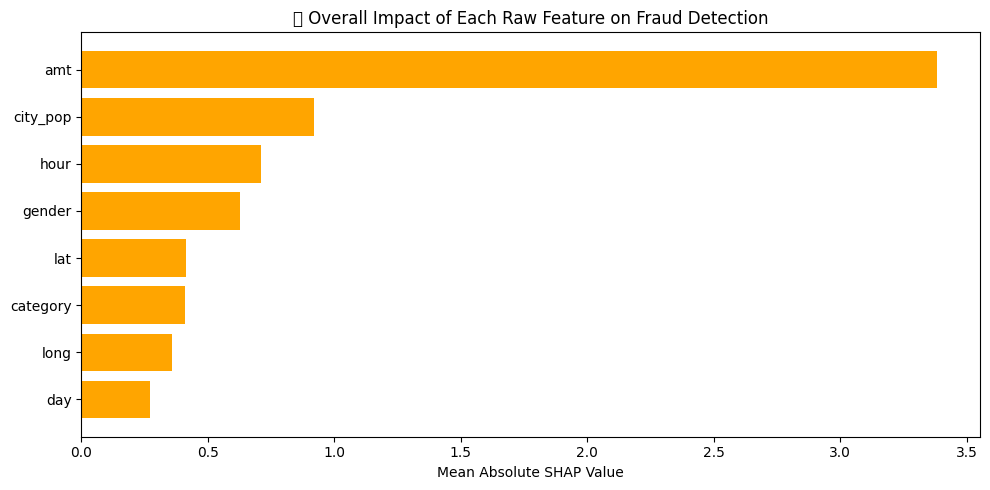

In [7]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load trained model and feature names
model = joblib.load("fraud_model.pkl")
feature_names = joblib.load("model_features.pkl")  # list of one-hot column names

# Load data
df = pd.read_csv("fraud_balanced.csv")
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day

# Prepare raw input features
features = ['amt', 'gender', 'city_pop', 'category', 'lat', 'long', 'hour', 'day']
X_raw = df[features]

# One-hot encode raw features like training
X_encoded = pd.get_dummies(X_raw)

# Align columns with training data
X_encoded = X_encoded.reindex(columns=feature_names, fill_value=0)

# Explain with SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_encoded)

# Group SHAP values by original raw feature names
group_map = defaultdict(list)
for i, col in enumerate(feature_names):
    if "gender_" in col:
        group_map['gender'].append(i)
    elif "category_" in col:
        group_map['category'].append(i)
    else:
        group_map[col].append(i)

# Compute mean absolute SHAP value per feature group
feature_scores = {}
for base_feat, idxs in group_map.items():
    vals = np.abs(shap_values.values[:, idxs])
    feature_scores[base_feat] = vals.mean()

# Sort and plot
sorted_feats = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
names, scores = zip(*sorted_feats)

plt.figure(figsize=(10, 5))
plt.barh(names[::-1], scores[::-1], color='orange')
plt.title("🔍 Overall Impact of Each Raw Feature on Fraud Detection")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()
